In [1]:
import os
classes = os.listdir('./akustik_data/')
classes

['arkaplan', 'insan', 'hayvan', 'arac']

In [2]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense

2022-04-17 15:23:17.931252: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
meta = []

for i in range(1,26):
    meta.append(['arac', 'x%d' % i])
    
for i in range(26,51):
    meta.append(['arkaplan', 'x%d' % i])
    
for i in range(51,76):
    meta.append(['hayvan', 'x%d' % i])
    
for i in range(76,101):
    meta.append(['insan', 'x%d' % i])

In [7]:
import numpy as np

NUM_FEATURES = 128

def features_extractor(file_name, NUM_FEATURES):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=NUM_FEATURES)
    
    mfccs_features = mfccs_features.T
    #mfccs_features = mfccs_features.reshape((1, mfccs_features.shape[0], mfccs_features.shape[1]))
    
    return mfccs_features[:700]


extracted_features=[]

for c, filename in meta:
    
    file_name = f"./downsample/{filename}.wav"

    data =features_extractor(file_name, NUM_FEATURES)
    extracted_features.append([data, c])

In [8]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature', 'class'])
extracted_features_df.head(10)

,feature,class
0,"[[-252.69997, 157.74219, -14.976885, 43.705845...",arac
1,"[[-241.23976, 171.48753, 7.499474, 39.061058, ...",arac
2,"[[-230.91533, 106.09454, 17.360027, 36.846504,...",arac
3,"[[-150.06833, 241.7922, -36.47016, 7.4844136, ...",arac
4,"[[-222.76315, 202.01587, -35.510597, 26.660997...",arac
5,"[[-134.91563, 159.38596, 20.196404, 28.565296,...",arac
6,"[[-200.31755, 168.40308, -40.759666, 0.6482765...",arac
7,"[[-198.80725, 176.5911, -1.5869819, 45.292442,...",arac
8,"[[-172.58052, 225.5242, -63.19178, 44.00025, 4...",arac
9,"[[-185.34874, 228.64188, -88.755264, 19.502235...",arac


In [9]:
import tensorflow as tf

padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    extracted_features_df['feature'].tolist(), padding="post")

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

y=np.array(extracted_features_df['class'].tolist())

labelencoder=LabelEncoder()
yold = y.copy()
y=to_categorical(labelencoder.fit_transform(y))

In [11]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf


skf = StratifiedKFold(n_splits=5)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import *

ypreds = np.zeros((len(padded_inputs),4))

for tr, val in skf.split(padded_inputs, yold):

    tf.random.set_seed(3)
    X_train = padded_inputs[tr]
    X_val = padded_inputs[val]
    Y_train = np.array([y[ind].tolist() for ind in tr]).astype(np.float32)
    Y_val = np.array([y[ind].tolist() for ind in val]).astype(np.float32)

    inp = Input(shape=(None,NUM_FEATURES))
    x = LSTM(5,return_sequences= True )(inp)
    x = LSTM(5, )(x)
    x = Dense(8,activation='relu')(x)
    x = Dense(16,activation='relu')(x)
    out = Dense(4,activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    break
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose = 0)

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(X_train, Y_train, batch_size=1, epochs=500, validation_data=(X_val, Y_val), verbose =1, callbacks = [es])

    ypreds[val] = model.predict(X_val)

2022-04-17 15:26:51.751677: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-17 15:26:51.782244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 15:26:51.782488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.77GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-04-17 15:26:51.782515: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-17 15:26:51.804561: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-17 15:26:51.804646: I tensorflow/stream_executor/platform

In [8]:
model.()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 128)]       0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 5)           2680      
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense (Dense)                (None, 8)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 3,160
Trainable params: 3,160
Non-trainable params: 0
___________________________________________________________

In [8]:
from sklearn.metrics import *

curacc = accuracy_score(np.argsort(y,axis=1)[:,-1], np.argsort(ypreds,axis=1)[:,-1])
print(curacc)

0.803680981595092


In [14]:
y_test = np.argsort(y,axis=1)[:,-1]
y_pred = np.argsort(ypreds,axis=1)[:,-1]

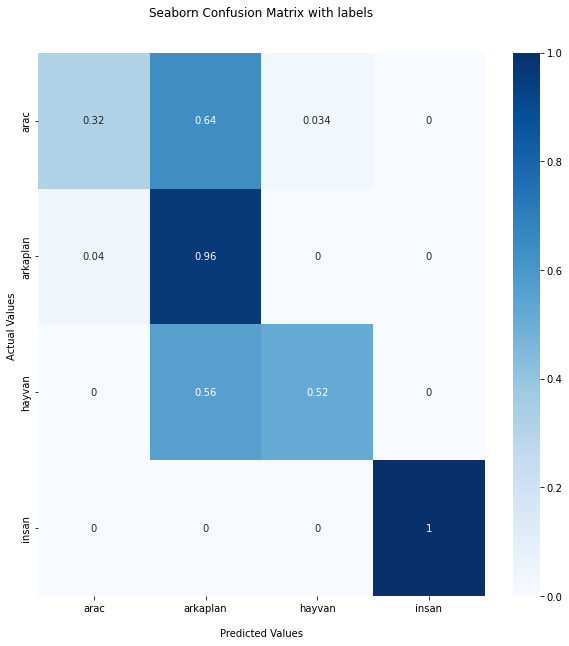

In [15]:
class_format = labelencoder.classes_.tolist()

import seaborn as sns
import matplotlib.pyplot as plt 


fig = plt.figure(figsize=(10,10))
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix,axis=1), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_format)
ax.yaxis.set_ticklabels(class_format)

## Display the visualization of the Confusion Matrix.
plt.show()